In [20]:
import importlib
import helper, consts
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [21]:
TEST_DATE = "20211201"
FILE_PATH = "../Data/"

features_filename = "Hoang_lasso_genetic_algo_features.txt"
with open(features_filename, 'r') as file:
    FEATURES = [line.strip("\n") for line in file]

class_data = helper.Data(train_data_path=FILE_PATH)

### Classification Tree for Feature Selection

In [22]:
importlib.reload(consts); importlib.reload(helper)

<module 'helper' from '/Users/hoangchu/Documents/Clinic/code_final/helper.py'>

In [23]:
transform_func = lambda x: 1 if x > 0 else (-1 if x < 0 else 0)

In [24]:
class_data.update_and_get_train_df(TEST_DATE, backward_dayCount = 1)
class_data.update_and_get_test_df(data_path=FILE_PATH, start_date=TEST_DATE)
class_data.transform_col("classification", col_name = consts.RESPONSE_NAME, transform_func = transform_func)

Getting files from 2021-11-29 00:00:00 to 2021-11-30 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.


In [25]:
train_y = class_data.train_df[consts.RESPONSE_NAME]
train_X = class_data.train_df.drop(consts.RESPONSE_NAME, inplace=False, axis = consts.COL)

test_y = class_data.test_dfs[0][consts.RESPONSE_NAME]
test_X = class_data.test_dfs[0].drop(consts.RESPONSE_NAME, inplace=False, axis = consts.COL)

In [26]:
class_weight = {-1:1,1:1.2}

model1 = helper.Model("DecisionTreeClassifier", hyperparam_dict = {"random_state": 0, "class_weight": class_weight})
model1.remove_metric()
model1.add_metric('correctness', lambda pred_y, actual_y: sum(pred_y == actual_y) / len(actual_y))

path = model1.inner.cost_complexity_pruning_path(train_X, train_y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

You're using: DecisionTreeClassifier.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [27]:
alphas = np.arange(0, max(ccp_alphas), .01)

train_df = class_data.train_df
test_df = class_data.test_dfs[0]

You're using: DecisionTreeClassifier.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
You're using: DecisionTreeClassifier.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
You're using: DecisionTreeClassifier.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperpara

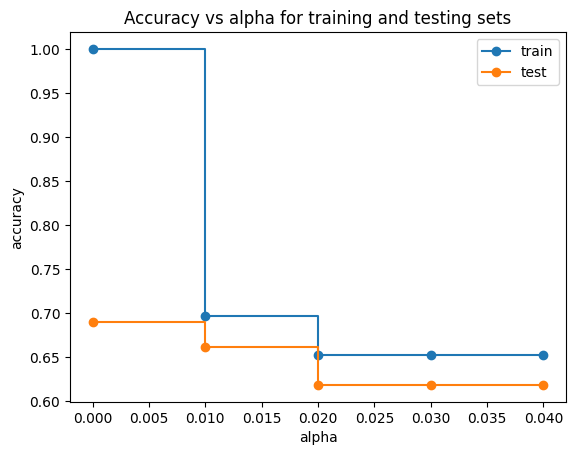

In [28]:
train_scores = []; test_scores = []
for alpha in alphas:
    kwarg = {"random_state": 0, "class_weight": class_weight, "ccp_alpha": alpha}
    model = helper.Model("DecisionTreeClassifier", hyperparam_dict = kwarg)
    model.remove_metric()
    model.add_metric("accuracy", lambda x, y: np.sum([x[i] == y[i] for i in range(len(x))]) / len(x))
    model.train(train_df, feature_col_names=FEATURES, verbose = False)
    
    model.test(train_df, verbose = False); train_scores.append(model.metric_output["accuracy"])
    model.test(test_df, verbose = False); test_scores.append(model.metric_output["accuracy"])
    
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [29]:
ALPHA = 0.02

In [30]:
kwarg2 = {"random_state": 0, "class_weight": class_weight, "ccp_alpha": ALPHA}
model2 = helper.Model("DecisionTreeClassifier", hyperparam_dict = kwarg)
model2.remove_metric()
model2.add_metric("accuracy", lambda x, y: np.sum([x[i] == y[i] for i in range(len(x))]) / len(x))
model2.train(train_df, feature_col_names=FEATURES)
model2.test(test_df)

You're using: DecisionTreeClassifier.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
No. features being used: 94
accuracy: 0.6187465640461792


### Random Forest Classification

In [31]:
importlib.reload(consts); importlib.reload(helper)

<module 'helper' from '/Users/hoangchu/Documents/Clinic/code_final/helper.py'>

In [32]:
train_dfs = []
for i in range(30, 40):
    rf_data = helper.Data(train_data_path=FILE_PATH)
    rf_data.update_and_get_train_df(TEST_DATE, backward_dayCount = 1 + i)
    rf_data.update_and_get_test_df(data_path=FILE_PATH, start_date=TEST_DATE)
    
    try: rf_data.transform_col("classification", col_name = consts.RESPONSE_NAME, transform_func = transform_func)
    except: continue
    
    train_dfs.append(rf_data.train_df)

Getting files from 2021-10-30 00:00:00 to 2021-10-31 00:00:00, inclusive.
File w/ end date 2021-10-31 00:00:00 does not exist.
Please update 'backward_dayCount' or increase 'train_data_count' (currently 1).
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
Getting files from 2021-10-29 00:00:00 to 2021-10-30 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
Getting files from 2021-10-28 00:00:00 to 2021-10-29 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
Getting files from 2021-10-27 00:00:00 to 2021-10-28 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
Getting files from 2021-10-26 00:00:00 to 2021-10-27 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
Getting files from 2021-10-25 00:00:00 to 2021-10-26 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 

In [33]:
def filter_features(features, scores):
    return [feature for feature, score in zip(features, scores) if score > 0]

In [34]:
feature_important_scores = [0 for _ in range(len(FEATURES))]
for train_df in train_dfs:
    kwarg = {"random_state": 0, "bootstrap": False, "class_weight": class_weight, "ccp_alpha": ALPHA}
    rf_model = helper.Model("RandomForestClassifier", hyperparam_dict=kwarg)
    rf_model.train(train_df, feature_col_names=FEATURES, verbose=False)
    
    for i in range(len(FEATURES)):
        feature_important_scores[i] += rf_model.inner.feature_importances_[i]
filtered_features = filter_features(FEATURES, feature_important_scores)

You're using: RandomForestClassifier.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
You're using: RandomForestClassifier.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs

Getting files from 2021-10-31 00:00:00 to 2021-11-30 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-16 00:00:00, inclusive.


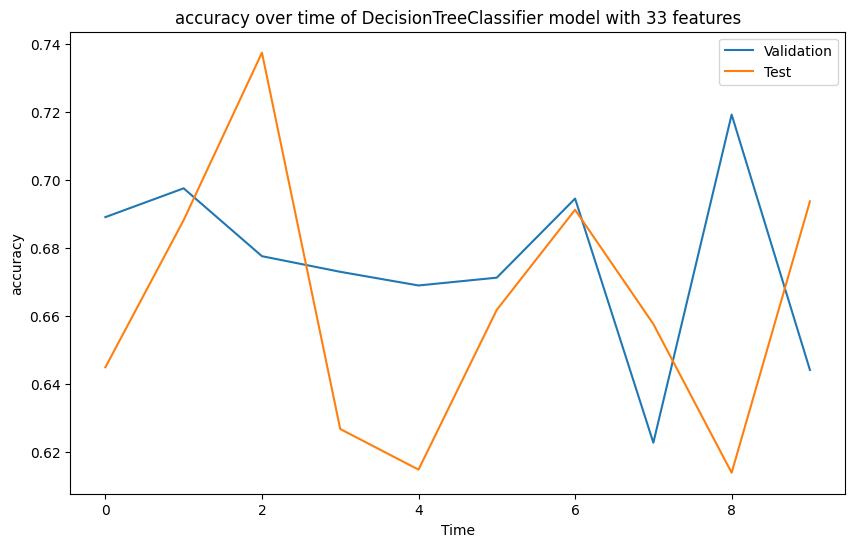

In [35]:
helper.classification_validation_plot(rf_data, transform_func, model2, 10, TEST_DATE, train_data_count= 30, 
                       data_path=FILE_PATH, forward_dayCount = 15, features = filtered_features)

#### Getting the final features and hyperparams

In [36]:
helper.extract_features_to_file(filtered_features, "Hoang_classTree_genetic_features.txt")